<a href="https://colab.research.google.com/github/Shritej24c/NLP101/blob/main/HW/HW7/ShritejShrikant_Chavan_HW_7_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'indianred'>**HW7_Handling_Longer_Sequences_Class_Imbalance: 20 Points** </font>


Homework 7 Instructions
In this assignment, you'll work with the StackExchange dataset from HW5, focusing on `basic_cleaned_text` and `Tag_Number_final`.
Changes from HW5
1. Data Filtering: Select rows from `basic_cleaned_text` with a word count > 400 (about 4000 samples).
2. Custom Collate Function: Develop a function for handling longer sequences. Break the document into smaller chunks (sub-parts).
3. Subclass Trainer:
   - Modify the `custom_loss` function for longer sequences and class imbalance.
   - For calculating loss, take the log probabilities for each chunk and average them to get document-level log probabilities, which should be used in your loss function.  
4. Aggregation Function: Create a function for aggregating predictions. - Similar to the loss function, make predictions based on aggregated log probabilities from chunks.
5. Evaluation Method: With the implementation of chunking, Trainer.Predict will become incompatible. Write your own function for evaluations.
Reference Files: Use `2_MultiClass_imbalanced_custom_Trainer.ipynb` and `4_imdb_bert_longer_seq_sliding_window_detailed.ipynb` from the `Final_files` in Lecture 10 folder.

In [1]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/NLP")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
import evaluate

from collections import Counter
import torch
from torch.utils.data import DataLoader

from scipy.special import softmax
from scipy.special import logsumexp

import wandb
import pandas as pd

# import functional from torch as F
import torch.nn.functional as F
from functools import partial
import gc


import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

import textwrap

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 34.9 MB/s eta 0:00:

In [2]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'datasets/Classification_HW/csv_files'
model_folder = base_folder/'models/nlp_spring_2023/HW7'
model_folder.mkdir(exist_ok=True)

In [3]:
def print_wrap(text, d):
    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)

## <font color = 'indianred'> **Exploring and Understanding Dataset**

## <font color = 'indianred'> **Stack Exchange MultiClass Dataset**</font>

- In this HW, you will identify tags for stack exchange Questions.
- This data is a subset of data available in a Kaggle Competition.
- The given dataset has different questions asked in the StackExchange website for various technical domains.
- We have fetched only those questions that contain the top 10 individual tags.
- **Each question has only one tag. This means that this is a <font color = "indianred">multi-class classification problem.**</font>
- These are the ten categories for tags in the data.

<div style="margin-left:5%">


| Index| Tag  |
|:-------:|:-------------:|
| 0     | C#          |
| 1     | java        |
| 2     | php         |
| 3     | javascript  |
| 4     | android     |
| 5     | jquery      |
| 6     | c++         |
| 7     | python      |
| 8     | iphone      |
| 9     | asp.net     |

</div>

## <font color = 'indianred'> **Load Data set**
    


In [4]:
# The file 'multiclass_hw_basic_clean.csv' is availaible on e-Learning 0_data_Folder
# Make sure that you specify the correct path
# The file name need to be in the string, thaat is why we have used str(file_path)
# We loaded imdb dataset from huggingface
# in this case we are creating a hugginmgface dataset from csv file
stack_dataset = load_dataset('csv', data_files= str(data_folder /'multiclass_hw_basic_clean.csv'))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

## <font color = 'indianred'> **Understanding your data**

In [5]:
print(stack_dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'Title', 'Body', 'cleaned_text', 'Tags', 'Tag_Number_final', 'combined_text', 'basic_cleaned_text'],
        num_rows: 188878
    })
})


## <font color = 'indianred'> **Understanding the datatype of columns**


In [6]:
stack_dataset['train'].features

{'Unnamed: 0.1': Value(dtype='int64', id=None),
 'Unnamed: 0': Value(dtype='int64', id=None),
 'Title': Value(dtype='string', id=None),
 'Body': Value(dtype='string', id=None),
 'cleaned_text': Value(dtype='string', id=None),
 'Tags': Value(dtype='string', id=None),
 'Tag_Number_final': Value(dtype='int64', id=None),
 'combined_text': Value(dtype='string', id=None),
 'basic_cleaned_text': Value(dtype='string', id=None)}

 - As you can see the dataset has lot of faeatures. However they are not all useful.
 - Title is the title of the stack exchange post
 - Body is the main text of the post
 - combined_text is Title and Body combined with no pre-processing
 - basic_cleaned_text is Title and Body combined with basic preprocessing (remove html tags, urls, emails).
 - cleaned_text - Here we have combined Body and Text and has done some motre pre-propcessing in addition to basic (removing stopwords, lammetization)
 - Tags - names of programming language to which the post belongs
 - Tag_Number_final - index corresponding to Tags

 - **Your goal in this HW is to predict Tags given Body and Title of the post**
 - **You will use Tag_Number_final and basic_cleaned_text for this HW**


## <font color = 'indianred'> **Acess indivdual element** </font>


In [7]:
# Assuming 'stack_dataset' is a huggingface dataset
# Select only the desired columns and rename them
selected_columns = {
    'text': stack_dataset['train']['basic_cleaned_text'],
    'label': stack_dataset['train']['Tag_Number_final']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)


In [8]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

In [9]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [10]:
stack_selected_columns['label'][:10]

[8, 4, 3, 9, 4, 0, 3, 2, 0, 7]

In [11]:
print_wrap(stack_selected_columns['text'][0], 80)

detail disclosure indicator on UIButton Is there a simple way to place a detail
disclosure icon on a UIButton? I'm using a navigation controller and I want a
button press to push a new view on the stack, so I thought a detail disclosure
icon would be appropriate, but I haven't found a straightforward way to do that
yet. What I have in mind is something like the "When Timer Ends" button in the
Timer subview of the Clock app.


In [12]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

## <font color = 'pickle'> **Filtering Larger Reviews**</font>

In [13]:
# Filter samples with more than 400 words
def filter_long_samples(example):

    return example['text'] is not None and len(example['text'].split()) > 400

stack_selected_columns = stack_selected_columns.filter(filter_long_samples)

Filter:   0%|          | 0/188878 [00:00<?, ? examples/s]

## <font color = 'indianred'> **Exploratory Data Analysis (EDA)**

### <font color = 'indianred'> **Change dataset format to Pandas**  </font>


In [152]:
# Set the format to Pandas
# CODE HERE

stack_selected_columns.set_format(type='pandas')


In [153]:
# get all rows the dataset
df = stack_selected_columns[:]


In [154]:
df.head()

,text,label
0,NullPointerException in OnCreate of inherited ...,4
1,List View OnitemClick Animation I did a list v...,4
2,uploading video file through ftp in android Hi...,4
3,C++ alternatives to preprocessor macro code ge...,6
4,Reading null values in a byte array c# I am tr...,0


In [155]:
# DO NOT RUN THIS CELL

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4772 entries, 0 to 4771
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4772 non-null   object
 1   label   4772 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 74.7+ KB


In [157]:
# DO NOT RUN THIS CELL

### <font color = 'indianred'> **Visualize distribution of class labels** </font>
It is important to undetrstand the distribution of the class labels to check if there is any imbalance among the categories.

<Axes: >

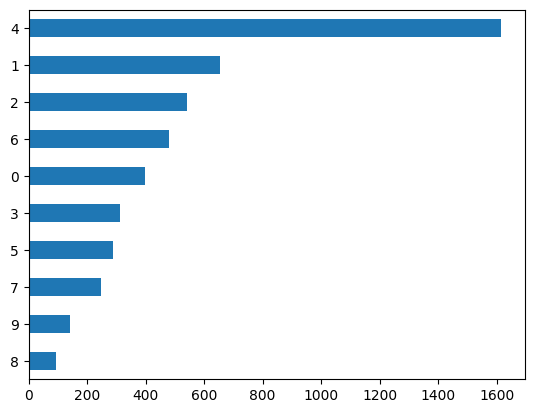

In [158]:
# Plot a horizontal bar chart showing the count of each unique value in the 'label' column of the dataframe 'df'.
# The counts are displayed in ascending order for better visualization of the distribution.
# CODE HERE
# check distribution of class labels in training dataset
df['label'].value_counts(ascending=True).plot.barh()

In [159]:
# DO NOT RUN THIS CELL

**Conclusions:**

From the above figure, we can clearly see the imbalance between labels. The most of the questions are of 'Android' Language and least from 'asp.net'


### Calculate Class Weights

In [160]:
# 1. Compute the class frequencies:
class_weights = df['label'].value_counts(normalize=True, sort=False)

print(class_weights)

# 2. Sort weights by index (i.e., by label):
class_weights = class_weights.sort_index()

# 3. Compute the inverse of the class frequencies:
class_weights = 1/class_weights

# 4. Normalize the weights so they sum up to 1 (this step is optional but can be useful):
class_weights = class_weights / class_weights.sum()

# 5. Convert the weights to a PyTorch tensor:
class_tensor_weights = torch.tensor(class_weights.values, dtype=torch.float)

4    0.338433
6    0.100587
0    0.083403
2    0.113789
3    0.065381
1    0.137469
8    0.019279
7    0.051551
5    0.060142
9    0.029966
Name: label, dtype: float64


In [161]:
class_tensor_weights

tensor([0.0675, 0.0410, 0.0495, 0.0862, 0.0166, 0.0937, 0.0560, 0.1093, 0.2922,
        0.1880])

In [162]:
sum(class_tensor_weights)

tensor(1.)

### <font color = 'indianred'> **Check length of the reviews** </font>


In [163]:
# Add empty strings for rows that do not have any text
df['text'] = df['text'].fillna('')

In [164]:
# Add a new column to the dataframe 'df' named 'words_per_review'.
# This column computes the number of words in each review in the 'text' column by splitting the text on spaces and counting the resulting words.
df['words_per_review'] = df['text'].apply(lambda x : len(x.split(' '))) # CODEE HERE



In [165]:
df.head()

,text,label,words_per_review
0,NullPointerException in OnCreate of inherited ...,4,1235
1,List View OnitemClick Animation I did a list v...,4,2875
2,uploading video file through ftp in android Hi...,4,2215
3,C++ alternatives to preprocessor macro code ge...,6,739
4,Reading null values in a byte array c# I am tr...,0,1400


In [166]:
# DO NOT RUN THIS CELL

#### <font color = 'indianred'> **Plot the distribution of review length** </font>

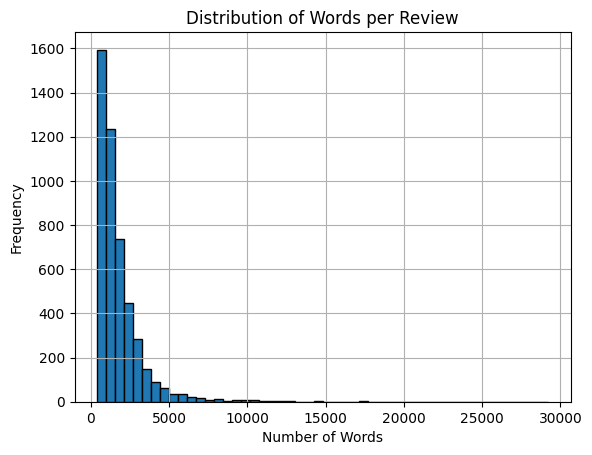

In [167]:
# Plot a histogram of the 'words_per_review' column
df['words_per_review'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Review')

# Display the plot
plt.show()


In [168]:
# The model we are going to use has token (subwords) limit of 512.
# Let us check how many reviews has more than 500 words

count = (df['words_per_review'] > 500).sum()
print(f"Number of reviews with more than 500 words: {count}")


Number of reviews with more than 500 words: 4559


In [169]:
# count the rows that do not have any text
count = (df['words_per_review'] ==0).sum()
print(f"Number of reviews with no text words: {count}")

Number of reviews with no text words: 0


In [170]:
# check the rows that have less than 20 words
count = (df['words_per_review'] <20).sum()
print(f"Number of reviews with less than 20 words: {count}")

Number of reviews with less than 20 words: 0


<Axes: title={'center': 'words_per_review'}, xlabel='label'>

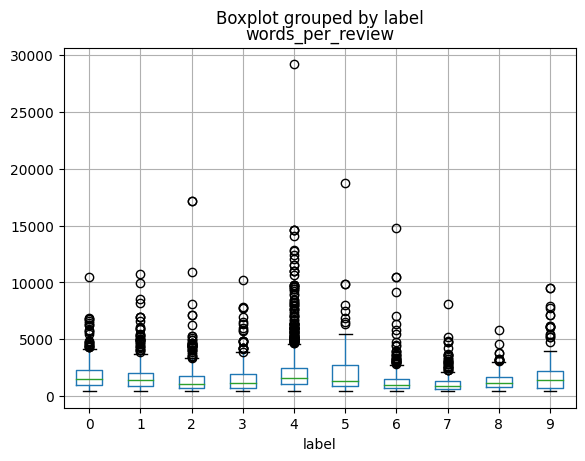

In [171]:
# distribution of number of words for each class label
df.boxplot('words_per_review', by='label')


- From the above graph, it seems that the distribution of number of words is similar for all the classes.
- Most models have max sequence length of 512. We have less than 1% observatins that have more than 512 words.

### <font color = 'indianred'> **Reset dataset format** </font>


In [172]:
# reset the format back to huggingface dataset
stack_selected_columns.reset_format()
# CODE HERE


## <font color = 'pickle'> **Data Pre-processing**</font>

### <font color = 'indianred'> **Create train, valid, test splits** </font>

In [14]:
# We know this information from how we created this dataset
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [15]:
# Cast the 'label' column of stack_selected_columns to the ClassLabel type with specified class names from class_names.
stack_selected_columns = stack_selected_columns.cast_column('label', ClassLabel(names = class_names))


Casting the dataset:   0%|          | 0/4772 [00:00<?, ? examples/s]

The code above modifies the label column of the stack_selected_columns data structure to represent categorical data using the class names provided in class_names. This will help us to keep the index and names mapping together.

In [16]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

In [17]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 4772
})

In [18]:
# Split the 'stack_selected_columns' dataset into training, validation, and test sets.
# The aim is to have 60% for training, 20% for validation, and 20% for testing.

# First, split the dataset into a 60% training set and a 40% temporary set (to be further split).
# Use stratified sampling based on the 'label' column to ensure that each split has a similar distribution of labels.
test_val_splits = stack_selected_columns.train_test_split(test_size= 0.4, seed=21, stratify_by_column='label') # CODE HERE

# Extract the 60% training dataset.
train_split = test_val_splits["train"] #CODE HERE


# Split the 40% temporary set into two equal parts: validation (20%) and test (20%).
# Again, use stratified sampling based on the 'label' column.
test_val_splits =  test_val_splits["test"].train_test_split(test_size= 0.5, seed=21, stratify_by_column='label') #CODE HERE

# Extract the validation and test datasets.
val_split = test_val_splits['train']# CODE HERE
test_split = test_val_splits['test'] # CODE HERE



In [19]:
stack_selected_columns_dict = DatasetDict({'train': train_split, 'val': val_split, 'test': test_split})

In [20]:
# combine train, val splits into one dataset
train_val_subset= DatasetDict({'train': train_split, 'val': val_split})

# create test dataset from test split
test_subset = DatasetDict({'test': test_split})



### <font color = 'pickle'> **Create subset for experimentation** </font>

In [21]:
train_split_small = train_split.shuffle(seed=42).select(range(10))
val_split_small = val_split.shuffle(seed=42).select(range(10))
test_split_small = test_split.shuffle(seed=42).select(range(10))


In [22]:
# combine train, val splits into one dataset
train_val_small= DatasetDict({'train': train_split_small, 'val': val_split_small})

# create test dataset from test split
test_small = DatasetDict({'test': test_split_small})

In [23]:
train_val_subset.set_format(type='pandas')

In [24]:
df_train = train_val_subset['train'][:]

<Axes: >

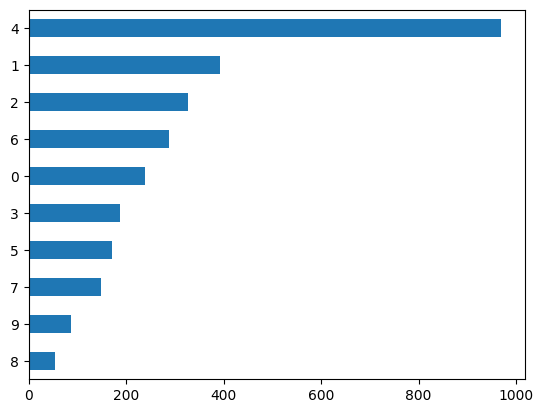

In [25]:
# check ditsribution of class labels in training dataset
df_train['label'].value_counts(ascending=True).plot.barh()

In [26]:
# Reset the format of train_val_subset to its original huggingface format
train_val_subset.reset_format()


In [27]:
# Retrieve the feature structures (data types and associated details) of the 'train' split from train_val_subset.
train_val_subset['train'].features


{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

In [28]:
# Cast the 'label' column of the entire train_val_subset to the ClassLabel type using the provided class names from class_names.
train_val_subset = train_val_subset.cast_column('label', ClassLabel(names = class_names)) # CODE HERE


Casting the dataset:   0%|          | 0/2863 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/954 [00:00<?, ? examples/s]

In [29]:
train_val_subset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

##  <font color = 'pickle'> **Create Custom_Collate function**

In [30]:
def collate_function(batch, tokenizer, max_length, stride):


    text_batch = [item['text'] for item in batch]

    # Check if any of the batch items has 'label', if so process labels.
    if all('label' in item for item in batch):
        label_batch = [item['label'] for item in batch]
        doc_labels = torch.tensor(label_batch, dtype=torch.long)
    else:
        doc_labels = None


    # Tokenize the batch of texts
    tokenized = tokenizer(text_batch,
                          padding='longest',
                          truncation=True,
                          return_tensors='pt',
                          max_length=max_length,
                          return_overflowing_tokens=True,
                          stride=stride)

    # Flatten the chunks if necessary using overflow_to_sample_mapping
    overflow_to_sample_mapping = tokenized.get("overflow_to_sample_mapping", None)

    result = {
        **tokenized,
        "overflow_to_sample_mapping": overflow_to_sample_mapping,
    }

    # Repeat labels for the chunks based on overflow_to_sample_mapping, only if labels are present
    if doc_labels is not None and overflow_to_sample_mapping is not None:
        labels = doc_labels[overflow_to_sample_mapping]
        result["labels"] = labels
        result["doc_labels"] = doc_labels

    return result


In [53]:
from collections import Counter
import torch

def cal_class_weights(input_tensor):
    # Convert the tensor to a list
    input_list = input_tensor.cpu().detach().numpy().tolist()

    counts = Counter(input_list)
    total = sum(counts.values())

    for key, value in counts.items():
        counts[key] = value / total

    # Convert counts dictionary to a Pandas Series
    import pandas as pd
    sd = pd.Series(counts).sort_index()

    class_weights = 1 / sd
    class_weights = class_weights / class_weights.sum()

    class_tensor_weights = torch.tensor(class_weights.values, dtype=torch.float)

    return class_tensor_weights



## Function to initialize model

In [41]:
def initialize_model(checkpoint, class_names):
    config = AutoConfig.from_pretrained(checkpoint)
    id2label = {}
    for id_, label_ in enumerate(class_names):
        id2label[str(id_)] = label_

    label2id = {}
    for id_, label_ in enumerate(class_names):
        label2id[label_] = id_

    config.id2label = id2label
    config.label2id = label2id

    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

    return model, config

## Aggregate Predictions

In [42]:

def stable_log_softmax(x):
    # Subtract the max for numerical stability along the last axis (axis=-1)
    x_max = np.max(x, axis=-1, keepdims=True)
    # Use logsumexp for better numerical stability
    log_softmax = x - x_max - logsumexp(x - x_max, axis=-1, keepdims=True)
    return log_softmax



def aggregate_predictions(logits, aggregation_method, overflow_to_sample_mapping):

    probabilities = softmax(logits, axis=-1)
    log_probabilities = stable_log_softmax(logits)

    # print('log_probs', log_probabilities.shape)
    # print('overflow_to_sample_mapping', overflow_to_sample_mapping.shape)

    # Get unique documents

    unique_docs, inverse_indices = np.unique(overflow_to_sample_mapping, return_inverse=True)
    num_docs = unique_docs.size

    # Create a mask for documents
    mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]

    # Initialize the aggregated_predictions variable
    aggregated_predictions = None

    if aggregation_method == "average_log_probs":
        # Compute average probabilities using NumPy
        avg_log_probs = (log_probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
        aggregated_predictions = np.argmax(avg_log_probs, axis=-1)
        scores = np.exp(avg_log_probs.max(axis=-1))

    elif aggregation_method == "average_probs":
        # Compute average probabilities using NumPy
        avg_probs = (probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
        aggregated_predictions = np.argmax(avg_probs, axis=-1)
        scores  = avg_probs.max(axis=-1)

    elif aggregation_method == "max_probs":
        # Compute max probabilities per document
        max_values = np.where(mask[:, :, None], log_probabilities[:, None, :], float('-inf'))
        max_log_probs = np.max(max_values, axis=0)
        aggregated_predictions = np.argmax(max_log_probs, axis=-1)
        scores = np.exp(max_log_probs.max(axis=-1))

    elif aggregation_method == "majority_vote":
        # Convert logits to actual predictions before voting
        predictions = np.argmax(logits, axis=1)
        # Tally the votes for each document
        vote_tally = np.zeros((num_docs, logits.shape[-1]), dtype=int)
        np.add.at(vote_tally, overflow_to_sample_mapping, np.eye(logits.shape[-1], dtype=int)[predictions])
        # Determine the majority vote for each document
        aggregated_predictions = np.argmax(vote_tally, axis=1)
        scores = vote_tally.max(axis=-1) / vote_tally.sum(axis=-1)
    else:
        raise ValueError(f"Unsupported aggregation_method: {aggregation_method}")

    # # Calculate evaluation metrics using document-level labels
    # metrics = evaluate.combine([
    #     evaluate.load("accuracy"),
    #     evaluate.load("f1", average="macro")
    # ])
    # evaluations = metrics.compute(predictions=aggregated_predictions, references=doc_labels)

    # return evaluations

    return aggregated_predictions, scores





## Custom Trainer

In [33]:
from transformers import Trainer
import torch
import torch.nn as nn
from transformers.trainer_utils import EvalPrediction


class CustomTrainer(Trainer):
    def __init__(self, *args, loss_type="average_log_probs", **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type
        self.nll_loss = nn.NLLLoss()


    def compute_loss(self, model, inputs, return_outputs=False):

        labels = inputs["labels"]
        overflow_to_sample_mapping = inputs.pop("overflow_to_sample_mapping", None)
        doc_labels = inputs.pop("doc_labels", None)
        logits = model(**inputs).logits

        # convert logits to log probabilities, probabilities
        log_probabilities = F.log_softmax(logits, dim=-1)
        probabilities = F.softmax(logits, dim=-1)


        # Number of unique documents and chunks
        num_docs = doc_labels.size(0)
        num_chunks = overflow_to_sample_mapping.size(0)

        # Ensure overflow_to_sample_mapping is on the same device as doc_labels
        overflow_to_sample_mapping = overflow_to_sample_mapping.to(doc_labels.device)

        # Create a tensor representing each unique doc
        unique_docs = torch.arange(num_docs).to(doc_labels.device)

        # Create the mask
        mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]

        loss_fn = self.nll_loss(weights = cal_class_weights(labels).to(model.device))


        if self.loss_type == "average_log_probs":
            avg_log_probs = (log_probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T

            # print('avg_log_probs_shape', avg_log_probs.shape)
            loss = loss_fn(avg_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "average_probs":
            avg_probs = (probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T

            avg_log_probs = torch.log(avg_probs)
            # print('avg_log_probs_shape', avg_log_probs.shape)
            loss = loss_fn(avg_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "max":
            max_values = torch.where(mask.unsqueeze(-1), log_probabilities[:, None, :], torch.tensor(float('-inf'), device=log_probabilities.device))
            max_log_probs = max_values.max(dim=0).values
            # print('max_log_probs_shape', max_log_probs.shape)
            loss = loss_fn(max_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "loss_per_chunk":
            # print('log_probs_shape', log_probabilities.shape)
            loss = loss_fn(log_probabilities, labels.view(-1))
            # print(loss)

        else:
            raise ValueError(f"Unsupported loss_type: {self.loss_type}")


        return (loss, logits) if return_outputs else loss



### Plot Confusion Matrix

In [34]:
def log_and_plot_confusion_matrix(trainer, tokenized_val_dataset, class_names):
    # Perform prediction using the trainer
    valid_output = trainer.predict(tokenized_val_dataset)

    # Convert the logits (raw prediction scores) from the valid_output object into class predictions.
    # For each input, pick the class with the highest logit as the predicted class.
    # Also, extract the true label IDs from valid_output and store them as an array for further analysis.
    valid_predictions = np.argmax(valid_output.predictions, axis=2)
    valid_labels = np.array(valid_output.label_ids)

    # 2. Filter out any tokens with label -100 (typically used for padding or special tokens)
    mask = valid_labels != -100
    filtered_predictions = valid_predictions[mask]
    filtered_labels = valid_labels[mask]

        # log the Confusion Matrix to Wandb
    wandb.log({
        "conf_mat": wandb.plot.confusion_matrix(
            preds=filtered_predictions,        # Model's predicted class labels.
            y_true=filtered_labels,      # Actual labels from the validation set.
            class_names=class_names   # Custom class names for display in the confusion matrix.
        )
    })

    # Plot the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_true=filtered_labels,
        y_pred=filtered_predictions,
        ax=ax,
        normalize="true",
        display_labels=class_names,
        xticks_rotation=90
    )
    plt.show()

## <font color = 'pickle'> **Set up Logger for experiments**</font>

### Function to set Trainer

In [35]:
def get_trainer(model, training_args, train_dataset, eval_dataset, loss_type, tokenizer, data_collator):
    trainer = CustomTrainer(
    loss_type = loss_type,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,

)
    return trainer

### Function to tokenize dataset and, train and eval models

In [36]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()

    gc.collect()

In [49]:
def tokenize_train_evaluate_log(training_args, checkpoint, base_folder,
                             class_names, train_val_subset, loss_type):
    # 1. Free memory
    free_memory()

    # 2. Setup wandb
    wandb.login()
    %env WANDB_PROJECT = nlp_course_fall_2023-HW7-PartA

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################

    # MAKE SURE THE BASE FOLDER IS SETUP CORRECTLY
    #  YOU CAN CHANGE THIS LINE IF YOU WANT TO SAVE IN A DIFFERENT FOLDER

    model_folder = base_folder / "models" / "nlp_spring_2023/HW7"/checkpoint
    model_folder.mkdir(exist_ok=True, parents=True)

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################


    # 3. Get Tokenized Dataset and Data Collator
    #train_val_tokenized_dataset = get_tokenized_dataset(checkpoint, train_val_subset)

    # 4. Initialize Model and Tokenizer
    model, config = initialize_model(checkpoint, class_names)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # 5. Initialize Trainer
    collate_fn = partial(collate_function, tokenizer=tokenizer,max_length = 512, stride = 16)

    trainer = get_trainer(model, training_args, train_val_subset['train'], train_val_subset['val'], loss_type, tokenizer, collate_fn)

    # 6. Train and Evaluate
    trainer.train()
    #trainer.evaluate(train_val_tokenized_dataset['val'])

    # 7. Log Metrics and Plot
    log_and_plot_confusion_matrix(trainer, train_val_subset['val'], class_names)

    best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
    wandb.log({"best_model_checkpoint_step": best_model_checkpoint_step})
    print(f"The best model was saved at step {best_model_checkpoint_step}.")

    wandb.finish()

    return best_model_checkpoint_step

## <font color = 'pickle'> **Hyperparameters and Checkpointing**</font>

In [50]:
from transformers import TrainingArguments

# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_fall_2023/imdb/bert"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=1,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=4,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,
    fp16= True, # Use mixed precision training for memroy optimization
    # argument for EvalPred to include inputs and outputs
    remove_unused_columns=False,


    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=1,  # Perform evaluation every 20 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=1,  # Save a model checkpoint every 20 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints

    # Use 'accuracy' as the metric to determine the best model
    # metric_for_best_model="accuracy",
    # greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=1,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='stack_HW7_1',  # Experiment name for Weights & Biases
)


##  <font color = 'pickle'> **Initialize Trainer**</font>

In [51]:
checkpoint = 'bert-base-uncased' # CODE HERE
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)


In [57]:
best_model = tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_small ,
                             loss_type = 'average_log_probs')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


env: WANDB_PROJECT=nlp_course_fall_2023-HW7-PartA


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: ignored

In [ ]:
torch.cuda.memory_summary(device=0, abbreviated=False)


In [56]:
torch.cuda.empty_cache()